In [ ]:
# import json
# from pymatgen.core import Structure
# from pymatgen.io.ase import AseAtomsAdaptor

# # Load the JSON file
# with open("sqs_structures_full_triangle.json") as f:
#     sqs_dicts = json.load(f)

# adaptor = AseAtomsAdaptor()
# sqs_structures = {}
# # (n_W, n_Ta, n_Nb) key
# for w_fraction, struct_dict in sqs_dicts.items():
#     # Convert dict -> pymatgen Structure
#     sqs_structures[w_fraction] = Structure.from_dict(struct_dict)

In [ ]:
# from elastic_utils import calculate_elasticity
# from fairchem.core import pretrained_mlip, FAIRChemCalculator
# from pymatgen.io.ase import AseAtomsAdaptor
# from ase.filters import FrechetCellFilter
# from tqdm import tqdm

# predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
# calc = FAIRChemCalculator(predictor, task_name="omat")

# ev_to_gpa = 160.2176621
# # Dictionary to store the results
# mlp_elastic_moduli = {}

# for name, pmg_struct in tqdm(sqs_structures.items()):
#     # Convert to ASE Atoms
#     atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    
#     # Calculate elasticity
#     results = calculate_elasticity(
#         atoms,
#         shear_strains= (-0.06, -0.03, 0.03, 0.06),
#         calculator=calc,
#         cell_filter_cls=FrechetCellFilter,
#         fix_symmetry=False,
#     )
    
#     # Convert to GPa
#     shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
#     bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
#     pugh_ratio = shear_gpa/bulk_gpa

#     # Extract elastic constants
#     elastic_tensor_6_6 = results['elastic_tensor'].voigt * ev_to_gpa
#     c11 = elastic_tensor_6_6[0][0]
#     c12 = elastic_tensor_6_6[0][1]
#     c44 = elastic_tensor_6_6[3][3]
#     # Store in dictionary
#     mlp_elastic_moduli[name] = {
#         'shear_modulus_vrh': shear_gpa,
#         'bulk_modulus_vrh': bulk_gpa,
#         'pugh_ratio': pugh_ratio,
#         'c11': c11,
#         'c12': c12,
#         'c44': c44
#     }
#     print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

In [ ]:
# import json
# from pymatgen.core import Structure

# # --- Load existing SQS structures ---
# input_path = "sqs_structures_full_triangle.json"
# output_path = "sqs_structures_full_triangle_with_elastic.json"

# with open(input_path) as f:
#     sqs_dicts = json.load(f)

# # --- Combine with mlp_elastic_moduli ---
# # Expect keys like '(n_W, n_Ta, n_Nb)' in mlp_elastic_moduli
# updated_sqs = {}

# for key, struct_dict in sqs_dicts.items():
#     # Ensure consistent key format
#     try:
#         n_W, n_Ta, n_Nb = eval(key)
#         alloy_key = f"({n_W}, {n_Ta}, {n_Nb})"
#     except Exception:
#         alloy_key = key  # fallback in case already matches

#     updated_entry = struct_dict.copy()

#     if alloy_key in mlp_elastic_moduli:
#         updated_entry["elastic_properties"] = mlp_elastic_moduli[alloy_key]
#     else:
#         updated_entry["elastic_properties"] = None  # optional for missing entries

#     updated_sqs[key] = updated_entry

# # --- Save updated JSON ---
# with open(output_path, "w") as f:
#     json.dump(updated_sqs, f, indent=2)

# print(f"✅ Updated JSON saved to:\n{output_path}")
# print(f"Total entries with elastic data: {sum(v['elastic_properties'] is not None for v in updated_sqs.values())}")

In [ ]:
import json
import pandas as pd

# Load the JSON file
with open("sqs_structures_full_triangle_with_elastic.json") as f:
    sqs_dicts = json.load(f)

# Extract elastic properties
elastic_data = []

for comp_key, entry in sqs_dicts.items():
    elastic = entry.get("elastic_properties", {})
    if not elastic:
        continue  # skip if no elastic data

    # Collect values safely
    C11 = elastic.get("c11")
    C12 = elastic.get("c12")
    C44 = elastic.get("c44")
    bulk_modulus = elastic.get("bulk_modulus_vrh")
    shear_modulus = elastic.get("shear_modulus_vrh")
    pugh_ratio = elastic.get("pugh_ratio")

    # store along with alloy composition key
    elastic_data.append({
        "composition_key": comp_key,
        "C11": C11,
        "C12": C12,
        "C44": C44,
        "bulk_modulus": bulk_modulus,
        "shear_modulus": shear_modulus,
        "pugh_ratio": 1/pugh_ratio, # Invert Pugh ratio for consistency to be K/G
    })

# Convert to DataFrame for convenience
elastic_df = pd.DataFrame(elastic_data)
elastic_df

Pareto-front ternary alloys (W, Ta, Nb):
W8Ta1Nb1 | Melting point = 3557.0 K | Pugh = 2.155
W7Ta2Nb1 | Melting point = 3516.5 K | Pugh = 2.344
W6Ta3Nb1 | Melting point = 3476.0 K | Pugh = 2.608
W5Ta4Nb1 | Melting point = 3435.5 K | Pugh = 2.886
W4Ta5Nb1 | Melting point = 3395.0 K | Pugh = 3.169
W3Ta6Nb1 | Melting point = 3354.5 K | Pugh = 3.425
W2Ta7Nb1 | Melting point = 3314.0 K | Pugh = 3.651
W1Ta8Nb1 | Melting point = 3273.5 K | Pugh = 3.763
W1Ta7Nb2 | Melting point = 3216.5 K | Pugh = 3.928
W1Ta6Nb3 | Melting point = 3159.5 K | Pugh = 4.053
W1Ta4Nb5 | Melting point = 3045.5 K | Pugh = 4.165
W1Ta3Nb6 | Melting point = 2988.5 K | Pugh = 4.362
W1Ta2Nb7 | Melting point = 2931.5 K | Pugh = 4.460
W1Ta1Nb8 | Melting point = 2874.5 K | Pugh = 4.706


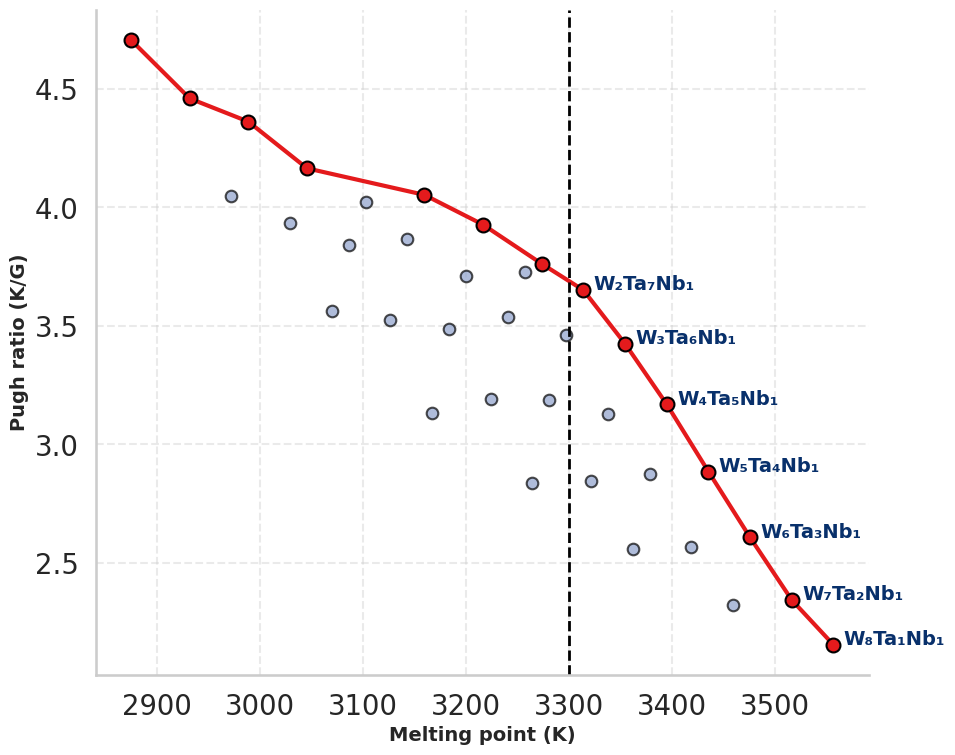

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot style setup ---
sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")

# --- Constants ---
total_atoms = 10
T_w, T_ta, T_nb = 3695, 3290, 2720  # Melting points (K)

# --- Data containers ---
melting_points, pugh_ratios, compositions = [], [], []

# --- Loop through alloys ---
for _, row in elastic_df.iterrows():
    key = row["composition_key"]
    n_W, n_Ta, n_Nb = eval(key)

    # Exclude non-ternary alloys (must have all 3 elements)
    if sum(x > 0 for x in [n_W, n_Ta, n_Nb]) != 3:
        continue

    # Compute melting point via Vegard's law
    w_frac, ta_frac, nb_frac = n_W / total_atoms, n_Ta / total_atoms, n_Nb / total_atoms
    T_alloy = (w_frac * T_w) + (ta_frac * T_ta) + (nb_frac * T_nb)

    # Compute Pugh ratio = K / G
    if row["shear_modulus"] > 0:  # Avoid division by zero
        pugh_ratio = row["bulk_modulus"] / row["shear_modulus"]
    else:
        continue

    melting_points.append(T_alloy)
    pugh_ratios.append(pugh_ratio)
    compositions.append((n_W, n_Ta, n_Nb))

# --- Convert to numpy arrays ---
melting_points = np.array(melting_points)
pugh_ratios = np.array(pugh_ratios)
compositions = np.array(compositions)

# --- Pareto front (maximize both melting point & Pugh ratio) ---
points = np.column_stack((melting_points, pugh_ratios))
sorted_idx = np.argsort(-melting_points)
pareto_points, pareto_compositions = [], []

best_pugh = -np.inf
for i in sorted_idx:
    T, pugh = points[i]
    if pugh > best_pugh:
        pareto_points.append((T, pugh))
        pareto_compositions.append(compositions[i])
        best_pugh = pugh

pareto_points = np.array(pareto_points)
pareto_compositions = np.array(pareto_compositions)

# --- Print Pareto compositions ---
print("Pareto-front ternary alloys (W, Ta, Nb):")
for (n_W, n_Ta, n_Nb), (T, pugh) in zip(pareto_compositions, pareto_points):
    print(f"W{n_W}Ta{n_Ta}Nb{n_Nb} | Melting point = {T:.1f} K | Pugh = {pugh:.3f}")

# --- Subscript helper ---
def subscript_number(num):
    sub_map = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return str(num).translate(sub_map)

def format_alloy_label(n_W, n_Ta, n_Nb):
    return f"W{subscript_number(n_W)}Ta{subscript_number(n_Ta)}Nb{subscript_number(n_Nb)}"

# --- Plot style ---
plt.figure(figsize=(10, 8))

# Scatter all alloys
plt.scatter(melting_points, pugh_ratios, 
            color='#8da0cb', alpha=0.7, s=70, edgecolor='k', label='All ternary alloys')

# Pareto front
plt.plot(pareto_points[:, 0], pareto_points[:, 1], 
         color='#e41a1c', lw=3, label='Pareto front')
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], 
            color='#e41a1c', s=100, edgecolor='k', zorder=5)

# Label Pareto points with subscripts - ONLY for melting points above 3300 K
for (n_W, n_Ta, n_Nb), (x, y) in zip(pareto_compositions, pareto_points):
    if x > 3300:
        label = format_alloy_label(n_W, n_Ta, n_Nb)
        # Manual vertical adjustment for overlapping alloys
        if (n_W, n_Ta, n_Nb) == (2, 6, 2):
            y += 0.02
        elif (n_W, n_Ta, n_Nb) == (1, 8, 1):
            y += 0.04
        plt.text(x + 10, y, label, fontsize=14, weight='bold', color='#08306b')

# Vertical line for T = 3300 K
plt.axvline(x=3300, color='black', linestyle='--', lw=2)
# plt.text(3320, plt.ylim()[1]*0.97, "T = 3300 K", fontsize=18, weight='bold', color='black', va='top')

# Horizontal line at Pugh ratio = 1 / 0.26 (black, no annotation)
# plt.axhline(y=1/0.26, color='black', linestyle='--', lw=2)

# Labels and style
plt.xlabel("Melting point (K)", fontsize=14, weight='bold')
plt.ylabel("Pugh ratio (K/G)", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
sns.despine()
plt.show()


<Figure size 1200x1000 with 0 Axes>

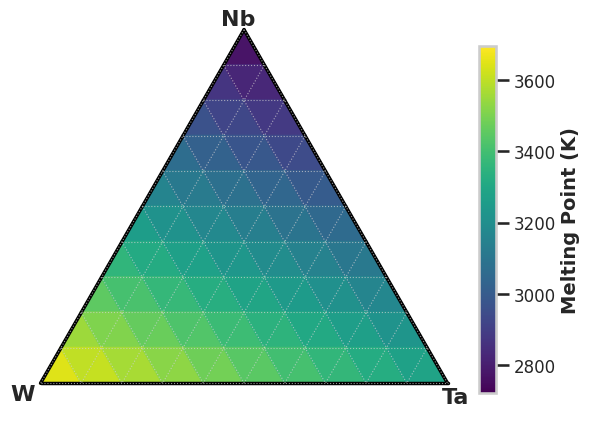

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

# --- Constants ---
total_atoms = 10
T_w, T_ta, T_nb = 3695, 3290, 2720

# --- Prepare data ---
points = {}
for _, row in elastic_df.iterrows():
    n_W, n_Ta, n_Nb = eval(row["composition_key"])
    
    # Include all alloys (ternary and binary)
    w_frac, ta_frac, nb_frac = n_W / total_atoms, n_Ta / total_atoms, n_Nb / total_atoms
    T_alloy = w_frac * T_w + ta_frac * T_ta + nb_frac * T_nb
    
    # Convert to integer coordinates that sum to total_atoms
    # Note: ternary uses (i, j, k) where i+j+k = scale
    points[(n_Ta, n_Nb, n_W)] = T_alloy

# Add pure element melting points at corners
# Pure W: (Ta=0, Nb=0, W=10) -> (0, 0, 10)
points[(0, 0, total_atoms)] = T_w

# Pure Ta: (Ta=10, Nb=0, W=0) -> (10, 0, 0)
points[(total_atoms, 0, 0)] = T_ta

# Pure Nb: (Ta=0, Nb=10, W=0) -> (0, 10, 0)
points[(0, total_atoms, 0)] = T_nb

# --- Create ternary plot ---
scale = total_atoms
plt.figure(figsize=(12, 10))

figure, tax = ternary.figure(scale=scale)

# Keep the triangular boundary
tax.boundary(linewidth=2.5)
tax.gridlines(color="lightgray", multiple=1, linewidth=0.8, alpha=0.7)

# Heatmap with better colormap
tax.heatmap(points, style="triangular", cmap='viridis', 
           colorbar=False, vmin=min(points.values()), vmax=max(points.values()))

# Enhanced colorbar
sm = plt.cm.ScalarMappable(cmap='viridis',
                           norm=plt.Normalize(vmin=min(points.values()), 
                                            vmax=max(points.values())))
sm.set_array([])
cbar = plt.colorbar(sm, ax=tax.get_axes(), shrink=0.85, pad=0.02)
cbar.set_label("Melting Point (K)", fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Remove axis labels - commented out
# tax.left_axis_label("Nb Fraction", fontsize=14, fontweight='bold', offset=0.15)
# tax.right_axis_label("W Fraction", fontsize=14, fontweight='bold', offset=0.15)
# tax.bottom_axis_label("Ta Fraction", fontsize=14, fontweight='bold', offset=0.1)

# Remove ticks
tax.clear_matplotlib_ticks()

# Add corner labels for pure elements - positioned near corners but outside triangle
tax.annotate("W", (-0.3, -0.3, scale+0.3), fontsize=16, fontweight='bold', 
            ha='center', va='center')
tax.annotate("Ta", (scale+0.4, -0.4, -0.4), fontsize=16, fontweight='bold', 
            ha='center', va='center')
tax.annotate("Nb", (-0.3, scale+0.3, -0.3), fontsize=16, fontweight='bold', 
            ha='center', va='center')

# Remove the rectangular box around the plot
ax = tax.get_axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
tax.show()

In [12]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.lattice.cubic import BodyCenteredCubic
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
pure_elastic_moduli = {}

for element in tqdm(["W", 'Ta', 'Nb']):
    atoms = BodyCenteredCubic(element).repeat(2)

    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        shear_strains= (-0.06, -0.03, 0.03, 0.06),
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa/bulk_gpa

    # Extract elastic constants
    elastic_tensor_6_6 = results['elastic_tensor'].voigt * ev_to_gpa
    c11 = elastic_tensor_6_6[0][0]
    c12 = elastic_tensor_6_6[0][1]
    c44 = elastic_tensor_6_6[3][3]
    # Store in dictionary
    pure_elastic_moduli[element] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
        'c11': c11,
        'c12': c12,
        'c44': c44
    }
    print(f"{element}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

 33%|███▎      | 1/3 [00:08<00:16,  8.01s/it]

W: Shear = 157.27 GPa, Bulk = 303.81 GPa, Pugh Ratio = 0.52


 67%|██████▋   | 2/3 [00:13<00:06,  6.69s/it]

Ta: Shear = 48.81 GPa, Bulk = 189.59 GPa, Pugh Ratio = 0.26


100%|██████████| 3/3 [00:19<00:00,  6.60s/it]

Nb: Shear = 24.98 GPa, Bulk = 159.47 GPa, Pugh Ratio = 0.16


<Figure size 1200x1000 with 0 Axes>

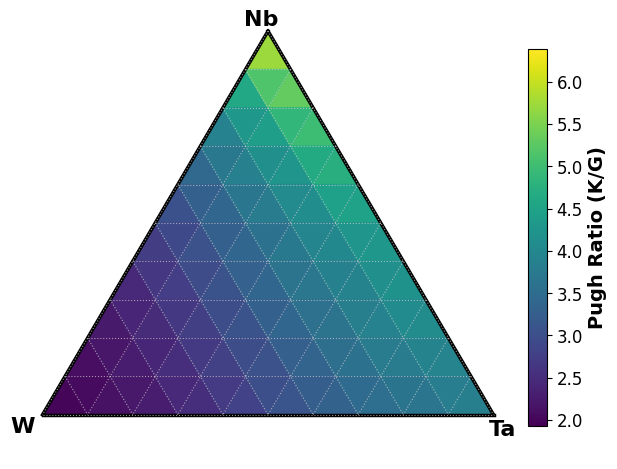

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

# --- Constants ---
total_atoms = 10

# --- Prepare data ---
points = {}
for _, row in elastic_df.iterrows():
    n_W, n_Ta, n_Nb = eval(row["composition_key"])
    
    # Get Pugh ratio from the data
    pugh_ratio = row["pugh_ratio"]
    
    # Skip if no Pugh ratio data
    if pd.isna(pugh_ratio):
        continue
    
    # Convert to integer coordinates that sum to total_atoms
    # Note: ternary uses (i, j, k) where i+j+k = scale
    points[(n_Ta, n_Nb, n_W)] = pugh_ratio

# Add pure element Pugh ratios at corners from pure_elastic_moduli
# Pure W: (Ta=0, Nb=0, W=10) -> (0, 0, 10)
points[(0, 0, total_atoms)] = 1/pure_elastic_moduli['W']['pugh_ratio']

# Pure Ta: (Ta=10, Nb=0, W=0) -> (10, 0, 0)
points[(total_atoms, 0, 0)] = 1/pure_elastic_moduli['Ta']['pugh_ratio']

# Pure Nb: (Ta=0, Nb=10, W=0) -> (0, 10, 0)
points[(0, total_atoms, 0)] = 1/pure_elastic_moduli['Nb']['pugh_ratio']

# --- Create ternary plot ---
scale = total_atoms
plt.figure(figsize=(12, 10))

figure, tax = ternary.figure(scale=scale)

# Keep the triangular boundary
tax.boundary(linewidth=2.5)
tax.gridlines(color="lightgray", multiple=1, linewidth=0.8, alpha=0.7)

# Heatmap with better colormap
tax.heatmap(points, style="triangular", cmap='viridis', 
           colorbar=False, vmin=min(points.values()), vmax=max(points.values()))

# Enhanced colorbar
sm = plt.cm.ScalarMappable(cmap='viridis',
                           norm=plt.Normalize(vmin=min(points.values()), 
                                            vmax=max(points.values())))
sm.set_array([])
cbar = plt.colorbar(sm, ax=tax.get_axes(), shrink=0.85, pad=0.02)
cbar.set_label("Pugh Ratio (K/G)", fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Remove ticks
tax.clear_matplotlib_ticks()

# Add corner labels for pure elements - positioned near corners but outside triangle
tax.annotate("W", (-0.3, -0.3, scale+0.3), fontsize=16, fontweight='bold', 
            ha='center', va='center')
tax.annotate("Ta", (scale+0.4, -0.4, -0.4), fontsize=16, fontweight='bold', 
            ha='center', va='center')
tax.annotate("Nb", (-0.3, scale+0.3, -0.3), fontsize=16, fontweight='bold', 
            ha='center', va='center')

# Remove the rectangular box around the plot
ax = tax.get_axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
tax.show()

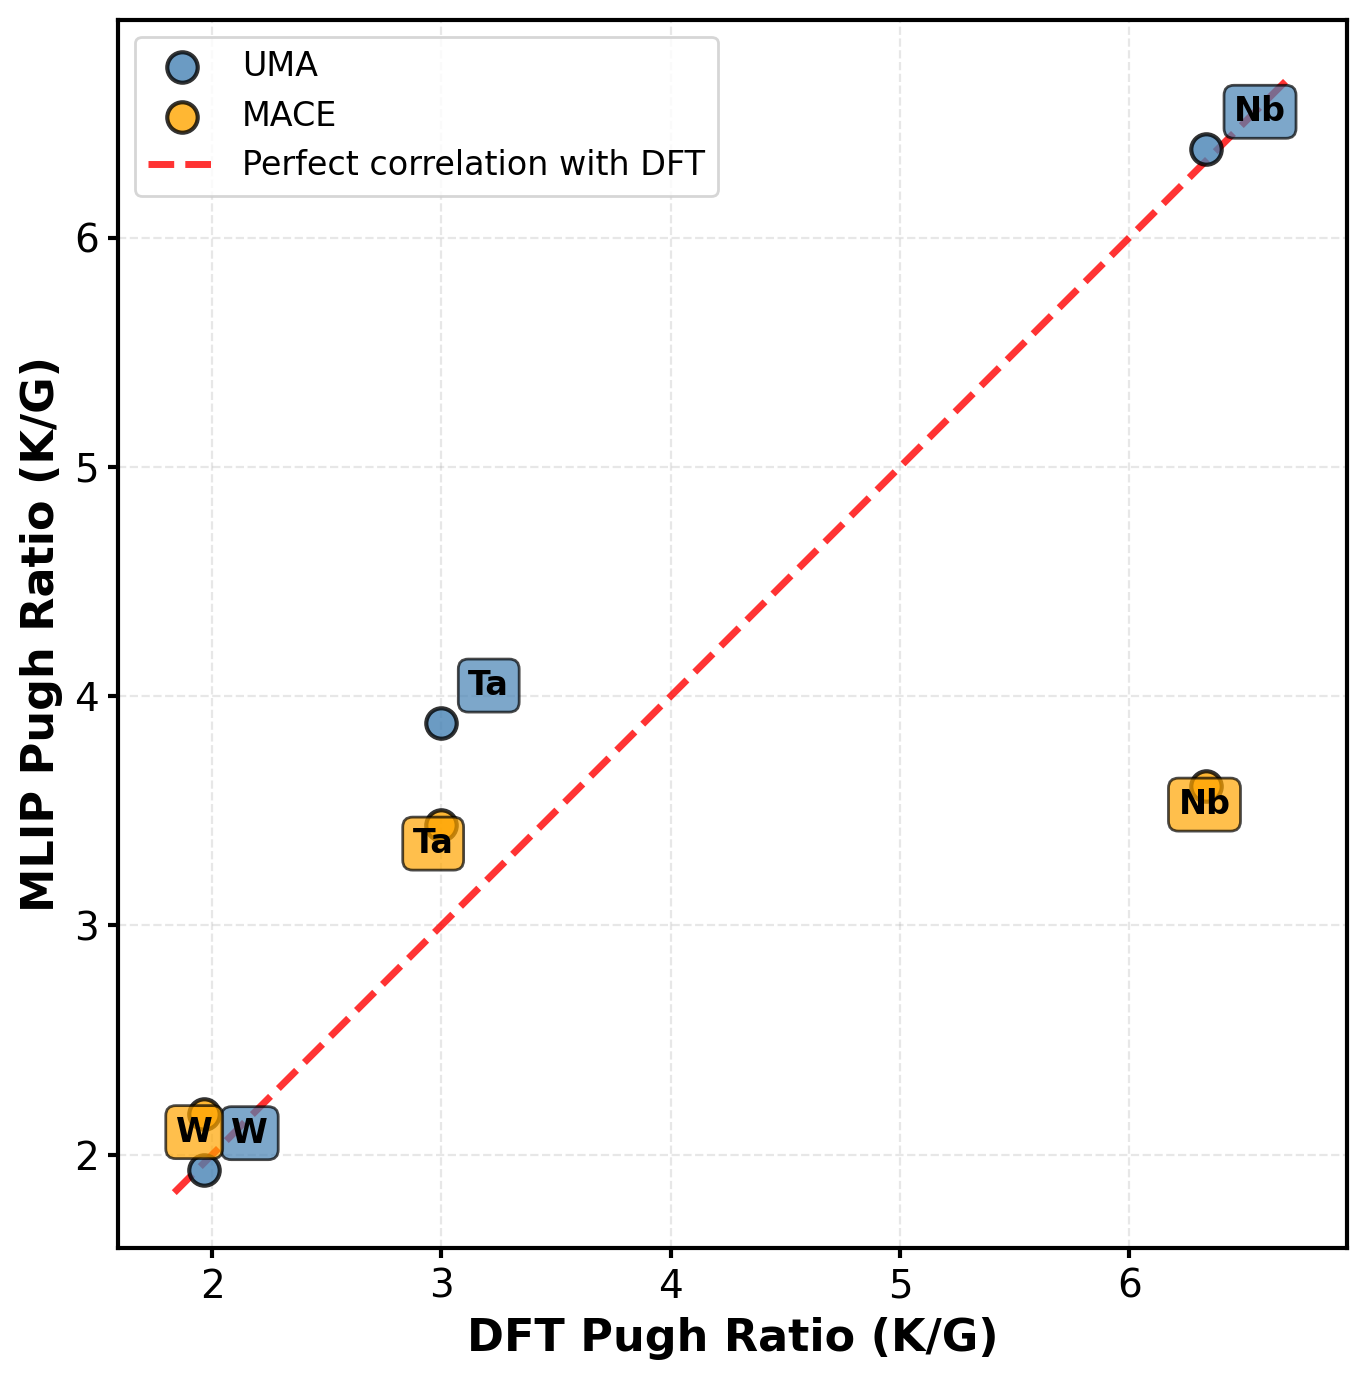

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extract data ---
elements = list(pure_elastic_moduli.keys())

# DFT data (reference)
dft_pure_bulk = np.array([332.333593, 200.935440, 184.236123])
dft_pure_shear = np.array([169.309423, 67.062816, 29.080316])
dft_pugh = dft_pure_bulk / dft_pure_shear

# UMA data (from dictionary)
uma_pure_bulk = np.array([pure_elastic_moduli[e]['bulk_modulus_vrh'] for e in elements])
uma_pure_shear = np.array([pure_elastic_moduli[e]['shear_modulus_vrh'] for e in elements])
uma_pugh = uma_pure_bulk / uma_pure_shear

# MACE data
mace_pure_bulk = np.array([335.99, 155.96, 158.34])
mace_pure_shear = np.array([154.22, 45.38, 43.90])
mace_pugh = mace_pure_bulk / mace_pure_shear

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 7), dpi=200)

# Scatter plot for UMA
ax.scatter(dft_pugh, uma_pugh,
           s=120, alpha=0.8, color='steelblue',
           edgecolors='black', linewidth=1.5, zorder=3, label='UMA-OMAT')

# Scatter plot for MACE
ax.scatter(dft_pugh, mace_pugh,
           s=120, alpha=0.8, color='orange',
           edgecolors='black', linewidth=1.5, zorder=3, label='MACE-OMAT')

# Perfect correlation line (y = x)
min_val = min(np.min(dft_pugh), np.min(uma_pugh), np.min(mace_pugh))
max_val = max(np.max(dft_pugh), np.max(uma_pugh), np.max(mace_pugh))
line_range = np.linspace(min_val * 0.95, max_val * 1.05, 100)
ax.plot(line_range, line_range, '--', color='red', linewidth=2.5,
        alpha=0.8, label='Perfect correlation with DFT', zorder=2)

# Add element labels for UMA points
for i, element in enumerate(elements):
    ax.annotate(element,
                (dft_pugh[i], uma_pugh[i]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='steelblue', alpha=0.7, edgecolor='black'))

# Add element labels for MACE points
for i, element in enumerate(elements):
    ax.annotate(element,
                (dft_pugh[i], mace_pugh[i]),
                xytext=(-10, -10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7, edgecolor='black'))

# Labels and title
ax.set_xlabel('DFT Pugh Ratio (K/G)', fontsize=16, fontweight='bold')
ax.set_ylabel('MLIP Pugh Ratio (K/G)', fontsize=16, fontweight='bold')

# Add legend
ax.legend(fontsize=12, loc='upper left')

# Styling
ax.tick_params(axis='both', which='major', labelsize=14, width=1.5)
ax.grid(True, alpha=0.3, linestyle='--')

# Make spines more prominent
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Equal aspect ratio and tight layout
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

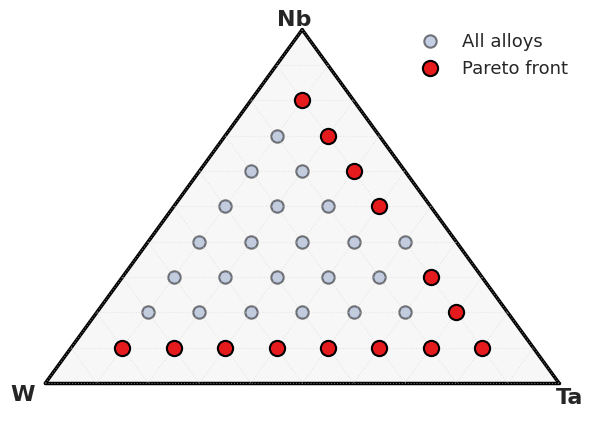

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ternary

# --- Plot style setup ---
sns.set_context("talk", font_scale=1.2)
sns.set_style("white")  # match ternary style

# --- Constants ---
total_atoms = 10

# --- Convert Pareto compositions to ternary coordinates ---
# Ternary library expects (Ta, Nb, W)
pareto_coords = [(n_Ta, n_Nb, n_W) for n_W, n_Ta, n_Nb in pareto_compositions]

# Optionally: all points for background (light grey/blue)
all_coords = [(n_Ta, n_Nb, n_W) for n_W, n_Ta, n_Nb in compositions]

# --- Create ternary plot ---
scale = total_atoms
plt.figure(figsize=(12, 10))
figure, tax = ternary.figure(scale=scale)

# Draw triangular boundary and gridlines
tax.boundary(linewidth=2.5)
tax.gridlines(color="lightgray", multiple=1, linewidth=0.8, alpha=0.5)

# --- Scatter all points lightly in background ---
tax.scatter(all_coords, marker='o', color='#8da0cb', s=80, alpha=0.5, edgecolor='k', label='All alloys')

# --- Highlight Pareto points ---
tax.scatter(pareto_coords, marker='o', color='#e41a1c', s=120, edgecolor='k', label='Pareto front', zorder=5)

# --- Annotate corner elements ---
tax.annotate("W", (-0.3, -0.3, scale+0.3), fontsize=16, fontweight='bold', ha='center', va='center')
tax.annotate("Ta", (scale+0.4, -0.4, -0.4), fontsize=16, fontweight='bold', ha='center', va='center')
tax.annotate("Nb", (-0.3, scale+0.3, -0.3), fontsize=16, fontweight='bold', ha='center', va='center')

# Remove ticks
tax.clear_matplotlib_ticks()

# Legend
tax.legend(fontsize=13, loc='upper right', frameon=False)

# Remove rectangular axes box
ax = tax.get_axes()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
tax.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from pymatgen.io.vasp import Outcar
from pymatgen.analysis.elasticity import ElasticTensor

BASE_DIR = "../vasp_internal_elastic/pure"

def process_all_outcars(base_dir):
    rows = []

    for sub in sorted(os.listdir(base_dir)):
        folder = os.path.join(base_dir, sub)
        outcar_path = os.path.join(folder, "OUTCAR")

        if not os.path.isdir(folder) or not os.path.exists(outcar_path):
            print(f"⚠️ Skipping {folder}: no OUTCAR found.")
            continue

        try:
            out = Outcar(outcar_path)
            out.read_elastic_tensor()

            # Convert from kBar → GPa
            C_kbar = np.array(out.data["elastic_tensor"])
            C_gpa = C_kbar / 10.0

            # ✅ Convert from 6×6 Voigt form to full 4th-rank tensor
            tensor = ElasticTensor.from_voigt(C_gpa)

            rows.append({
                "system": sub,
                "C11": C_gpa[0, 0],
                "C12": C_gpa[0, 1],
                "C44": C_gpa[3, 3],
                "K_V": tensor.k_voigt,
                "K_R": tensor.k_reuss,
                "K_H": tensor.k_vrh,
                "G_V": tensor.g_voigt,
                "G_R": tensor.g_reuss,
                "G_H": tensor.g_vrh,
            })

            print(f"{sub}: K_H={tensor.k_vrh:.3f} GPa, G_H={tensor.g_vrh:.3f} GPa")

        except Exception as e:
            print(f"⚠️ Skipping {folder}: error reading OUTCAR ({e}).")
            continue

    return pd.DataFrame(rows)

df_sqs = process_all_outcars(BASE_DIR)
df_sqs['pugh_ratio'] = df_sqs['K_H'] / df_sqs['G_H']
df_sqs

nb: K_H=184.236 GPa, G_H=29.080 GPa
nb_mprelaxset: K_H=174.030 GPa, G_H=17.098 GPa
ta: K_H=200.935 GPa, G_H=67.063 GPa
ta_mprelaxset: K_H=189.473 GPa, G_H=54.155 GPa
w: K_H=332.334 GPa, G_H=169.309 GPa
w_mprelaxset: K_H=333.020 GPa, G_H=169.717 GPa


,system,C11,C12,C44,K_V,K_R,K_H,G_V,G_R,G_H,pugh_ratio
0,nb,258.39451,147.15693,18.25341,184.236123,184.236123,184.236123,33.199562,24.961070,29.080316,6.335424
1,nb_mprelaxset,267.31514,127.38712,2.79328,174.029793,174.029793,174.029793,29.661572,4.534768,17.098170,10.178270
2,ta,271.80008,165.50312,78.34763,200.935440,200.935440,200.935440,68.267970,65.857662,67.062816,2.996227
3,ta_mprelaxset,258.08050,155.16910,56.03280,189.472900,189.472900,189.472900,54.201960,54.107603,54.154781,3.498729
4,w,566.15064,215.42507,165.38992,332.333593,332.333593,332.333593,169.379066,169.239780,169.309423,1.962877
5,w_mprelaxset,593.45427,202.80279,154.50591,333.019950,333.019950,333.019950,170.833842,168.599725,169.716784,1.962210
